## Option pricing

In this example we study **American call options**.
They provide the right to buy a given asset at any time during some specified period at a strike price K. 


The market price of the asset at time t is denoted by $p_t$.

Let $$p_t = \rho p_{t-1} + b + \nu \epsilon_t \quad \text{with } \epsilon_t \sim N(0,1).$$

(this is a pretty bad assumption, because it implies that price changes are easily predictable)

The discount rate is $\beta = \frac{1}{1+r}$, where $r>0$ is a risk-free interest rate.

Upon exercising the option, the reward is equal to $p_t - K$.

The option is purchased at time $t=1$ and can be exercised until $t=T$.

Our task is find the price of the option $v(p,t)$. It satisfies $$v(p,t) = \max \left\{p - K, \; \beta E_{p} \left[ v(p^\prime,t+1) \right]  \right\}$$ with the boundary condition $$v(p,T+1)=0.$$

This is a **finite horizon** problem.

In [1]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages


  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`


In [3]:
# load some packages we will need today
using Distributions, QuantEcon, IterTools, Plots

In [4]:

function create_option_model(; T=200, # periods
    ρ=0.95, # price persistence
    ν=10, # price volatility
    b=6.0,
    K=85, # strike price
    β=0.99, # discount factor
    N=25) # grid size for Tauchen
    mc = tauchen(N, ρ, ν, b)
    return (; T, ρ, ν, b, K, β, N, mc)
    end

create_option_model (generic function with 1 method)

In [5]:
function T_operator(v,model)
    (;T, ρ, ν, b, K, β, N, mc) = model
    P = mc.p
    p_vec = mc.state_values
    σ_new        = [(p - K) >= (β * P[i,:]' * v) for (i, p) in enumerate(p_vec)]
    v_new        = σ_new .* (p_vec .- K) .+ (1 .- σ_new) .* (β * P * v);
    return v_new, σ_new
end

function vfi(model)
    (;T, ρ, ν, b, K, β, N, mc) = model
    
    v_matrix = zeros(N,T+1); σ_matrix = zeros(N,T)
    for t=T:-1:1 # backwards induction
        v_matrix[:,t], σ_matrix[:,t],  = T_operator(v_matrix[:,t+1],model)
    end
    return v_matrix, σ_matrix
end

vfi (generic function with 1 method)

In [6]:
model = create_option_model()
v_matrix,σ_matrix = vfi(model)

([35.34495517047747 35.34202568825348 … 0.0 0.0; 35.715432846535016 35.7125601560397 … 0.0 0.0; … ; 123.07048459279781 123.07048459279781 … 123.07048459279781 0.0; 131.0768922830522 131.0768922830522 … 131.0768922830522 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0])

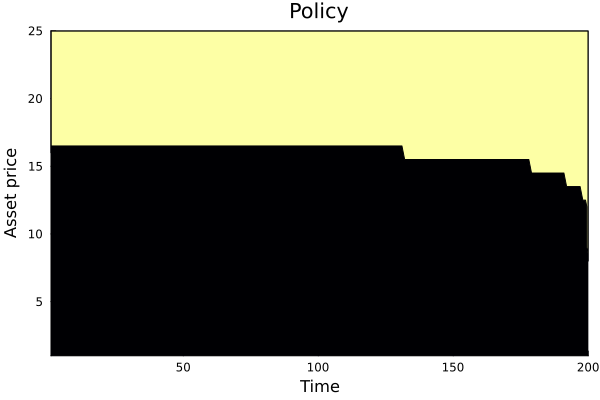

In [7]:
contour(σ_matrix, levels =1, fill=true,legend = false, cbar=false, xlabel="Time", ylabel="Asset price", title="Policy")



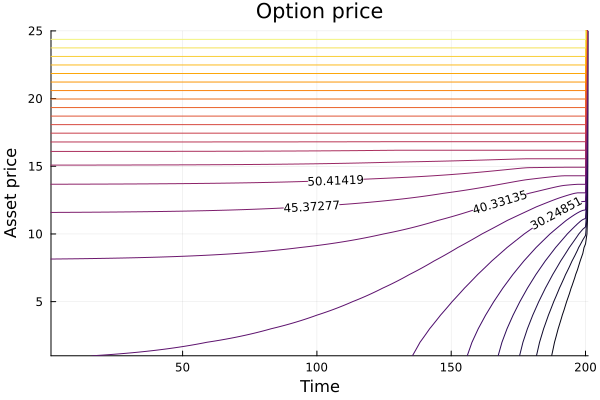

In [8]:
contour(v_matrix,levels = 25, cbar=false,clabels=true, xlabel="Time", ylabel="Asset price", title="Option price")

In [34]:
function sim_option(model, σ_matrix; init = 1)
    (;T, ρ, ν, b, K, β, N, mc) = model
    p_ind = simulate_indices(mc, T, init = init);
    p = mc.state_values[p_ind]
    strike = zeros(T)
    for t=1:T
        strike[t] = σ_matrix[p_ind[t],t]
    end
    return p, strike
    end

sim_option (generic function with 2 methods)

In [105]:
p, strike = sim_option(model, σ_matrix; init = 1)

([23.923107716947626, 23.923107716947626, 23.923107716947626, 23.923107716947626, 55.94873847796505, 55.94873847796505, 55.94873847796505, 63.95514616821941, 63.95514616821941, 63.95514616821941  …  111.99359230974554, 95.98077692923684, 103.98718461949119, 111.99359230974554, 103.98718461949119, 103.98718461949119, 95.98077692923684, 79.96796154872811, 79.96796154872811, 71.96155385847376], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

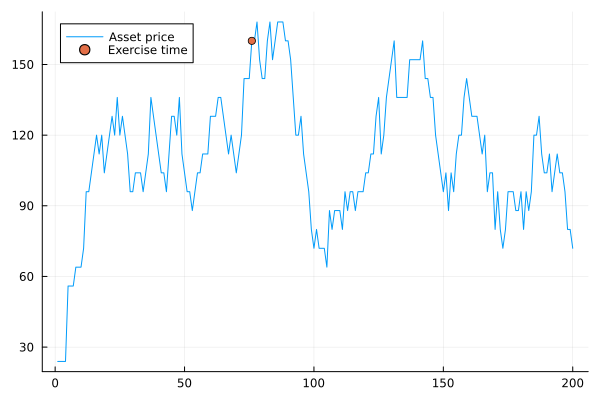

In [106]:
strike_time = findfirst(strike.==1)
plot(p, label="Asset price", legend=:topleft)
scatter!([strike_time],[p[strike_time]], label="Exercise time", legend=:topleft)

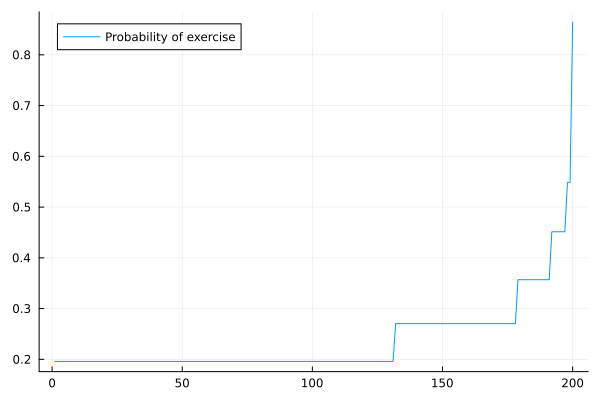

In [107]:

stationary_distributions(mc)[1]
prob_strike = zeros(T)
distr_strike = zeros(T)
for t = 1:T
    prob_strike[t] = sum( σ_matrix[i,t] * stationary_distributions(mc)[1][i] for i=1:N)
    if t > 1
    distr_strike[t] = (1-sum(distr_strike[1:t-1])) * prob_strike[t]
    else distr_strike[t] = prob_strike[t]
    end
end
plot(1:T,prob_strike, label="Probability of exercise", legend=:topleft)

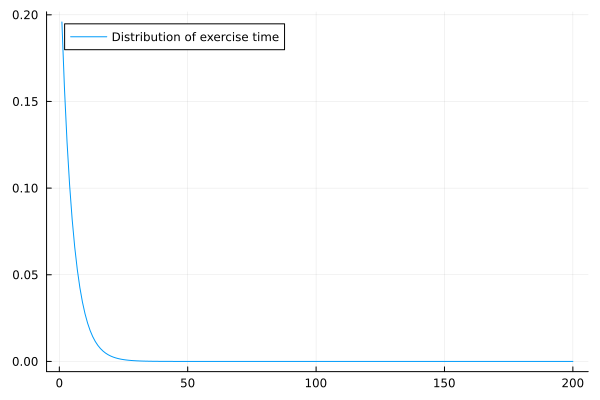

In [108]:
plot(1:T,distr_strike, label="Distribution of exercise time", legend=:topleft)



In [85]:
expected_exercise_time = sum(t * distr_strike[t] for t=1:T)

5.105899021145659